In [2]:
import numpy as np

from numpy.typing import NDArray

from nncore import nn
from nncore.nn import optim
from nncore.utils import chunks, sigmoid, tiles, randn, zeros, ones

np.random.seed(42)

Load MNIST dataset

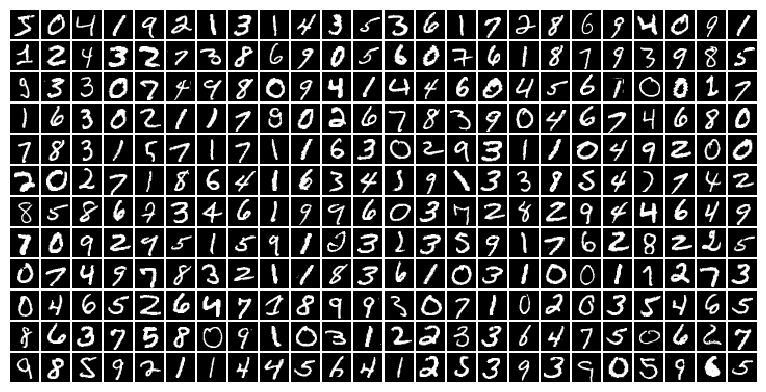

In [3]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

In [4]:
# Training set
X_train = mnist.train_images().astype(np.float32)
X_train = (X_train / 127.5) - 1.0
X_train = X_train.reshape(-1, 28 * 28)
np.random.shuffle(X_train)

size = 20_000
X_train = X_train[:size, ...]

Define generator and discriminator

In [5]:
LATENT_DIM = 128

G = nn.Sequential(
    nn.Linear(vsize=LATENT_DIM, hsize=128, init_method="He"),
    nn.ReLU(),
    nn.Linear(vsize=128, hsize=256, init_method="He"),
    nn.ReLU(),
    nn.Linear(vsize=256, hsize=512, init_method="He"),
    nn.ReLU(),
    nn.Linear(vsize=512, hsize=784, init_method="He"),
    nn.Tanh(),
)

D = nn.Sequential(
    nn.Linear(vsize=784, hsize=512, init_method="He"),
    nn.ReLU(),
    nn.Linear(vsize=512, hsize=128, init_method="He"),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(vsize=128, hsize=1, init_method="He"),
)

Check if generator works

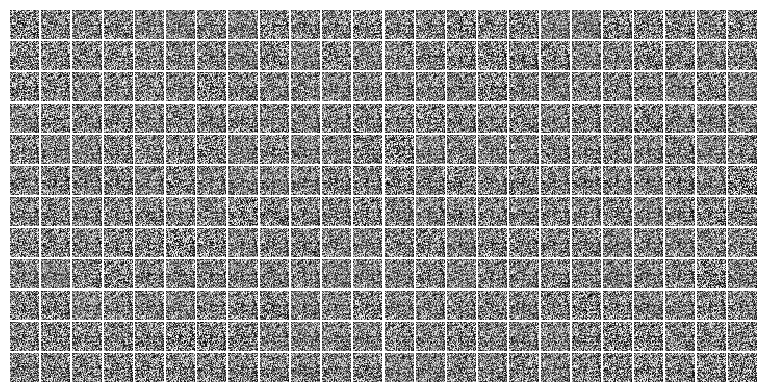

In [6]:
fixed_noise = randn(12 * 24, LATENT_DIM)
samples = G.forward(fixed_noise, training=False)
samples = samples.reshape(12, 24, 28, 28)
tiles(samples)

Define loss function

In [7]:
def cross_entropy(targets: NDArray, logits: NDArray, eps: float = 1e-8) -> float:
    batch_size = targets.shape[0]
    σ = sigmoid(logits)
    return -1 / batch_size * np.sum(targets * np.log(σ + eps) + (1 - targets) * np.log(1 - σ + eps))

Run training

Epoch   1 | G-Loss 2.78 | D-Loss 0.38:   0%|          | 0/200 [00:03<?, ?it/s]

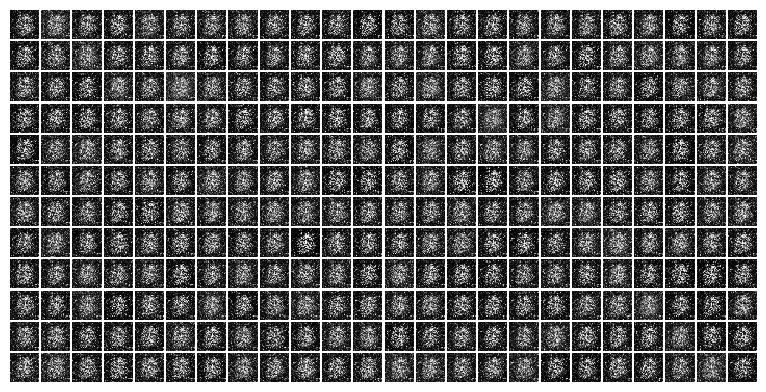

Epoch  50 | G-Loss 1.30 | D-Loss 0.52:  24%|██▍       | 49/200 [02:44<07:50,  3.12s/it]

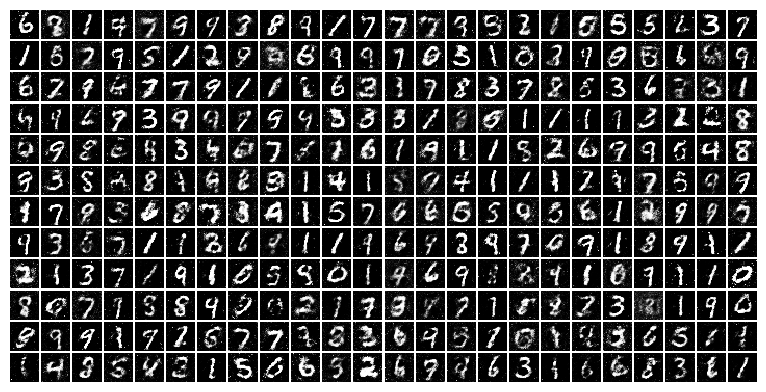

Epoch 100 | G-Loss 1.30 | D-Loss 0.52:  50%|████▉     | 99/200 [05:17<04:54,  2.92s/it]

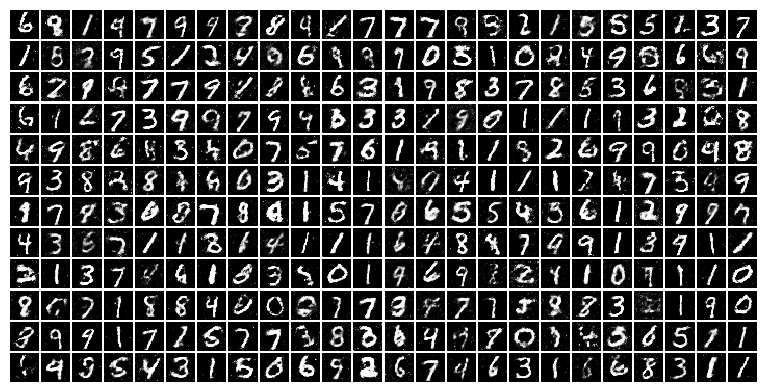

Epoch 150 | G-Loss 1.35 | D-Loss 0.50:  74%|███████▍  | 149/200 [07:49<02:48,  3.30s/it]

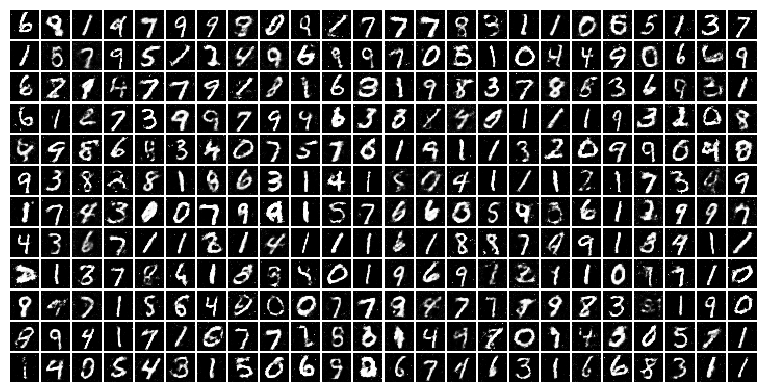

Epoch 200 | G-Loss 1.46 | D-Loss 0.48: 100%|█████████▉| 199/200 [10:14<00:03,  3.02s/it]

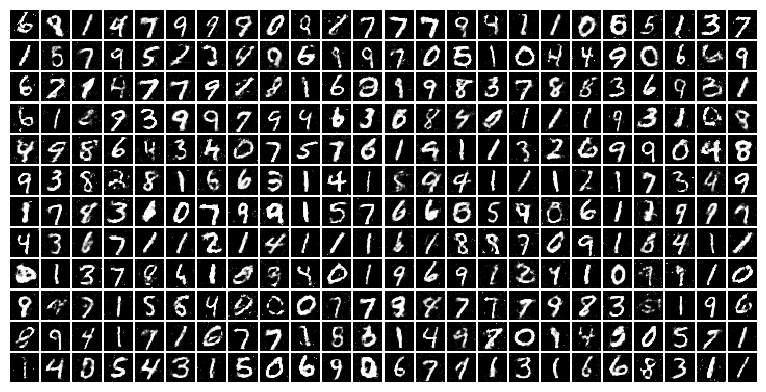

Epoch 200 | G-Loss 1.46 | D-Loss 0.48: 100%|██████████| 200/200 [10:14<00:00,  3.07s/it]


In [8]:
from math import ceil
from tqdm import trange

batch_size = 128
log_period = 50
num_epochs = 200

G.reset()
D.reset()

optim_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

for epoch in (pbar := trange(num_epochs)):
    total = ceil(len(X_train) / batch_size)
    dataloader = chunks(X_train, size=batch_size)

    running_loss_g = 0.0
    running_loss_d = 0.0

    for X_real in dataloader:
        n_samples = X_real.shape[0]

        noise = randn(n_samples, LATENT_DIM)
        X_fake = G.forward(noise, training=True)

        # -------------------
        # Train discriminator
        # -------------------
        X_batch = np.concat((X_real, X_fake))
        t_batch = np.concat((ones(n_samples, 1), zeros(n_samples, 1)))
        y_batch = D.forward(X_batch, training=True)

        loss_d = cross_entropy(t_batch, y_batch)
        grad_y = 1 / len(X_batch) * (sigmoid(y_batch) - t_batch)
        D.backward(grad_y)
        optim_d.apply(D.gradients())

        # ---------------
        # Train generator
        # ---------------
        t_adver = ones(n_samples, 1)
        y_adver = D.forward(X_fake, training=True)

        loss_g = cross_entropy(t_adver, y_adver)
        grad_y = 1 / len(X_fake) * (sigmoid(y_adver) - t_adver)
        grad_y = D.backward(grad_y)
        G.backward(grad_y)
        optim_g.apply(G.gradients())

        # Update running loss
        running_loss_g += loss_g
        running_loss_d += loss_d

    # Log progress
    epoch_loss_g = running_loss_g / total
    epoch_loss_d = running_loss_d / total
    pbar.set_description(f"Epoch {epoch+1:>3d} | G-Loss {epoch_loss_g:>2.2f} | D-Loss {epoch_loss_d:>2.2f}")

    if epoch == 0 or (epoch + 1) % log_period == 0:
        samples = G.forward(fixed_noise, training=False)
        samples = samples.reshape(12, 24, 28, 28)
        tiles(samples)